### Import Pacakges

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

### Load Data

We combine the data in Training and Testing Sets directory instead of directly using the full dataset

In [2]:
dataset_1 = pd.read_csv('./CSV Files/UNSW-NB15_1.csv')
dataset_2 = pd.read_csv('./CSV Files/UNSW-NB15_2.csv')
dataset_3 = pd.read_csv('./CSV Files/UNSW-NB15_3.csv')
dataset_4 = pd.read_csv('./CSV Files/UNSW-NB15_4.csv')

description = pd.read_csv('./CSV Files/NUSW-NB15_features.csv', encoding='cp1252')

description

dataset_1.columns = description['Name'] 
dataset_2.columns = description['Name'] 
dataset_3.columns = description['Name'] 
dataset_4.columns = description['Name'] 


df = pd.concat([dataset_1, dataset_2, dataset_3, dataset_4])

df.info()

/tmp/ipykernel_547197/382717313.py:1: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_1 = pd.read_csv('./CSV Files/UNSW-NB15_1.csv')
/tmp/ipykernel_547197/382717313.py:2: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_2 = pd.read_csv('./CSV Files/UNSW-NB15_2.csv')


<class 'pandas.core.frame.DataFrame'>
Index: 2540043 entries, 0 to 440042
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit              fl

In [3]:
description['Type']

0       nominal
1       integer
2       nominal
3       integer
4       nominal
5       nominal
6         Float
7       Integer
8       Integer
9       Integer
10      Integer
11      Integer
12      Integer
13      nominal
14        Float
15        Float
16      integer
17      integer
18      integer
19      integer
20      integer
21      integer
22      integer
23      integer
24      integer
25      integer
26        Float
27        Float
28    Timestamp
29    Timestamp
30        Float
31        Float
32        Float
33        Float
34        Float
35       Binary
36      Integer
37      Integer
38       Binary
39      integer
40      integer
41      integer
42      integer
43      integer
44      integer
45      integer
46      integer
47      nominal
48       binary
Name: Type, dtype: object

### Data Preprocessing

#### Check duplicated rows

In [4]:
duplicate_count = df.duplicated().sum()

duplicate_percentage = (duplicate_count / len(df)) * 100

print(f"Number of duplicate rows: {duplicate_count}")
print(f"Percentage of duplicate rows: {duplicate_percentage:.2f}%")


Number of duplicate rows: 480626
Percentage of duplicate rows: 18.92%


In [5]:
df = df.drop_duplicates()

#### Check missing value

In [6]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

missing_columns = missing_info[missing_info['Missing Values'] > 0]

if len(missing_columns) > 0:
    print("Columns with missing values:")
    print(missing_columns)
else:
    print("No missing values found in the dataset.")
    
# Get overall summary of missing values
print("\nTotal missing values:", df.isnull().sum().sum())
print("Percentage of missing data:", (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100, "%")


Columns with missing values:
                  Missing Values  Percentage (%)
Name                                            
ct_flw_http_mthd          933603       45.333364
is_ftp_login             1014165       49.245248
attack_cat               1959771       95.161446

Total missing values: 3907539
Percentage of missing data: 3.8722460714634783 %


In [7]:
# Fill missing values in is_ftp_login with 0 because 0 means no FTP login
df['is_ftp_login'] = df['is_ftp_login'].fillna(0)
# Fill missing values in ct_flw_http_mthd with 0 because 0 means no HTTP method
df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].fillna(0)

# We drop the 'attack_cat' column as it is not needed for the analysis
df = df.drop('attack_cat', axis=1)

#### Check NaN values

In [8]:
# Check for NaN values in each column
nan_values = df.isna().sum()
nan_percentage = (nan_values / len(df)) * 100

nan_info = pd.DataFrame({
    'NaN Values': nan_values,
    'Percentage (%)': nan_percentage
})

nan_columns = nan_info[nan_info['NaN Values'] > 0]

if len(nan_columns) > 0:
    print("Columns with NaN values:")
    print(nan_columns)
else:
    print("No NaN values found in the dataset.")
    
# Get overall summary of NaN values
print("\nTotal NaN values:", df.isna().sum().sum())
print("Percentage of NaN data:", (df.isna().sum().sum() / (df.shape[0] * df.shape[1])) * 100, "%")

# Check for infinite values
inf_count = np.isinf(df.select_dtypes(include=['float64', 'int64'])).sum().sum()
print(f"\nNumber of infinite values: {inf_count}")


No NaN values found in the dataset.

Total NaN values: 0
Percentage of NaN data: 0.0 %

Number of infinite values: 0


#### Check inconsistant type in columns

In [9]:
def check_df_type():
    # Create a comparison DataFrame
    type_comparison = pd.DataFrame({
        'Column': df.columns,
        'Current Type': df.dtypes
    })

    # Merge with description to get expected types
    type_comparison = type_comparison.merge(
        description[['Name', 'Type']],
        left_on='Column',
        right_on='Name',
        how='left'
    ).drop('Name', axis=1)

    # Add a column to show if types match
    def check_type_match(current, expected):
        if pd.isna(expected):
            return 'N/A'
        if expected.lower() == 'nominal' and current == 'object':
            return '✓'
        elif expected.lower() == 'integer' and current in ['int64', 'Int64']:
            return '✓'
        elif expected.lower() == 'float' and current == 'float64':
            return '✓'
        elif expected.lower() == 'binary' and current in ['int64', 'Int64']:
            return '✓'
        elif expected.lower() == 'timestamp' and current in ['int64', 'Int64']:
            return '✓'
        else:
            return '✗'

    type_comparison['Match'] = type_comparison.apply(
        lambda x: check_type_match(str(x['Current Type']), x['Type']), axis=1
    )

    # Show only mismatched types
    mismatches = type_comparison[type_comparison['Match'] == '✗']
    print("Columns with type mismatches:")
    print(mismatches.to_string(index=False))

    # Show the full type comparison
    print("\nFull type comparison:")
    print(type_comparison.to_string(index=False))


In [10]:
check_df_type()

Columns with type mismatches:
          Column Current Type    Type Match
           sport       object integer     ✗
          dsport       object integer     ✗
ct_flw_http_mthd      float64 Integer     ✗
    is_ftp_login      float64  Binary     ✗
      ct_ftp_cmd       object integer     ✗

Full type comparison:
          Column Current Type      Type Match
           srcip       object   nominal     ✓
           sport       object   integer     ✗
           dstip       object   nominal     ✓
          dsport       object   integer     ✗
           proto       object   nominal     ✓
           state       object   nominal     ✓
             dur      float64     Float     ✓
          sbytes        int64   Integer     ✓
          dbytes        int64   Integer     ✓
            sttl        int64   Integer     ✓
            dttl        int64   Integer     ✓
           sloss        int64   Integer     ✓
           dloss        int64   Integer     ✓
         service       object   nominal

In [11]:
df['sport'] = df['sport'].astype('str')
df['sport'] = pd.to_numeric(df['sport'], errors='coerce').fillna(0).astype(int)

df['dsport'] = df['dsport'].astype('str')
df['dsport'] = pd.to_numeric(df['dsport'], errors='coerce').fillna(0).astype(int)

df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].astype('int64')


In [12]:
df['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3, '0', '1', ' ', '2', '4'], dtype=object)

In [13]:
df['ct_ftp_cmd'] = df['ct_ftp_cmd'].replace(' ', '0')

df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').fillna(0).astype(int)

In [14]:
df['is_ftp_login'] = (df['is_ftp_login'] > 0).astype(int)

In [15]:
check_df_type()

Columns with type mismatches:
Empty DataFrame
Columns: [Column, Current Type, Type, Match]
Index: []

Full type comparison:
          Column Current Type      Type Match
           srcip       object   nominal     ✓
           sport        int64   integer     ✓
           dstip       object   nominal     ✓
          dsport        int64   integer     ✓
           proto       object   nominal     ✓
           state       object   nominal     ✓
             dur      float64     Float     ✓
          sbytes        int64   Integer     ✓
          dbytes        int64   Integer     ✓
            sttl        int64   Integer     ✓
            dttl        int64   Integer     ✓
           sloss        int64   Integer     ✓
           dloss        int64   Integer     ✓
         service       object   nominal     ✓
           Sload      float64     Float     ✓
           Dload      float64     Float     ✓
           Spkts        int64   integer     ✓
           Dpkts        int64   integer     ✓
  

#### Drop useless columns

In [16]:
columns_to_drop = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service', 'Stime', 'Ltime']
df = df.drop(columns=columns_to_drop)

### Data Analysis

In [17]:
y = df['Label']
X = df.drop('Label', axis=1)

#### Check outliors 

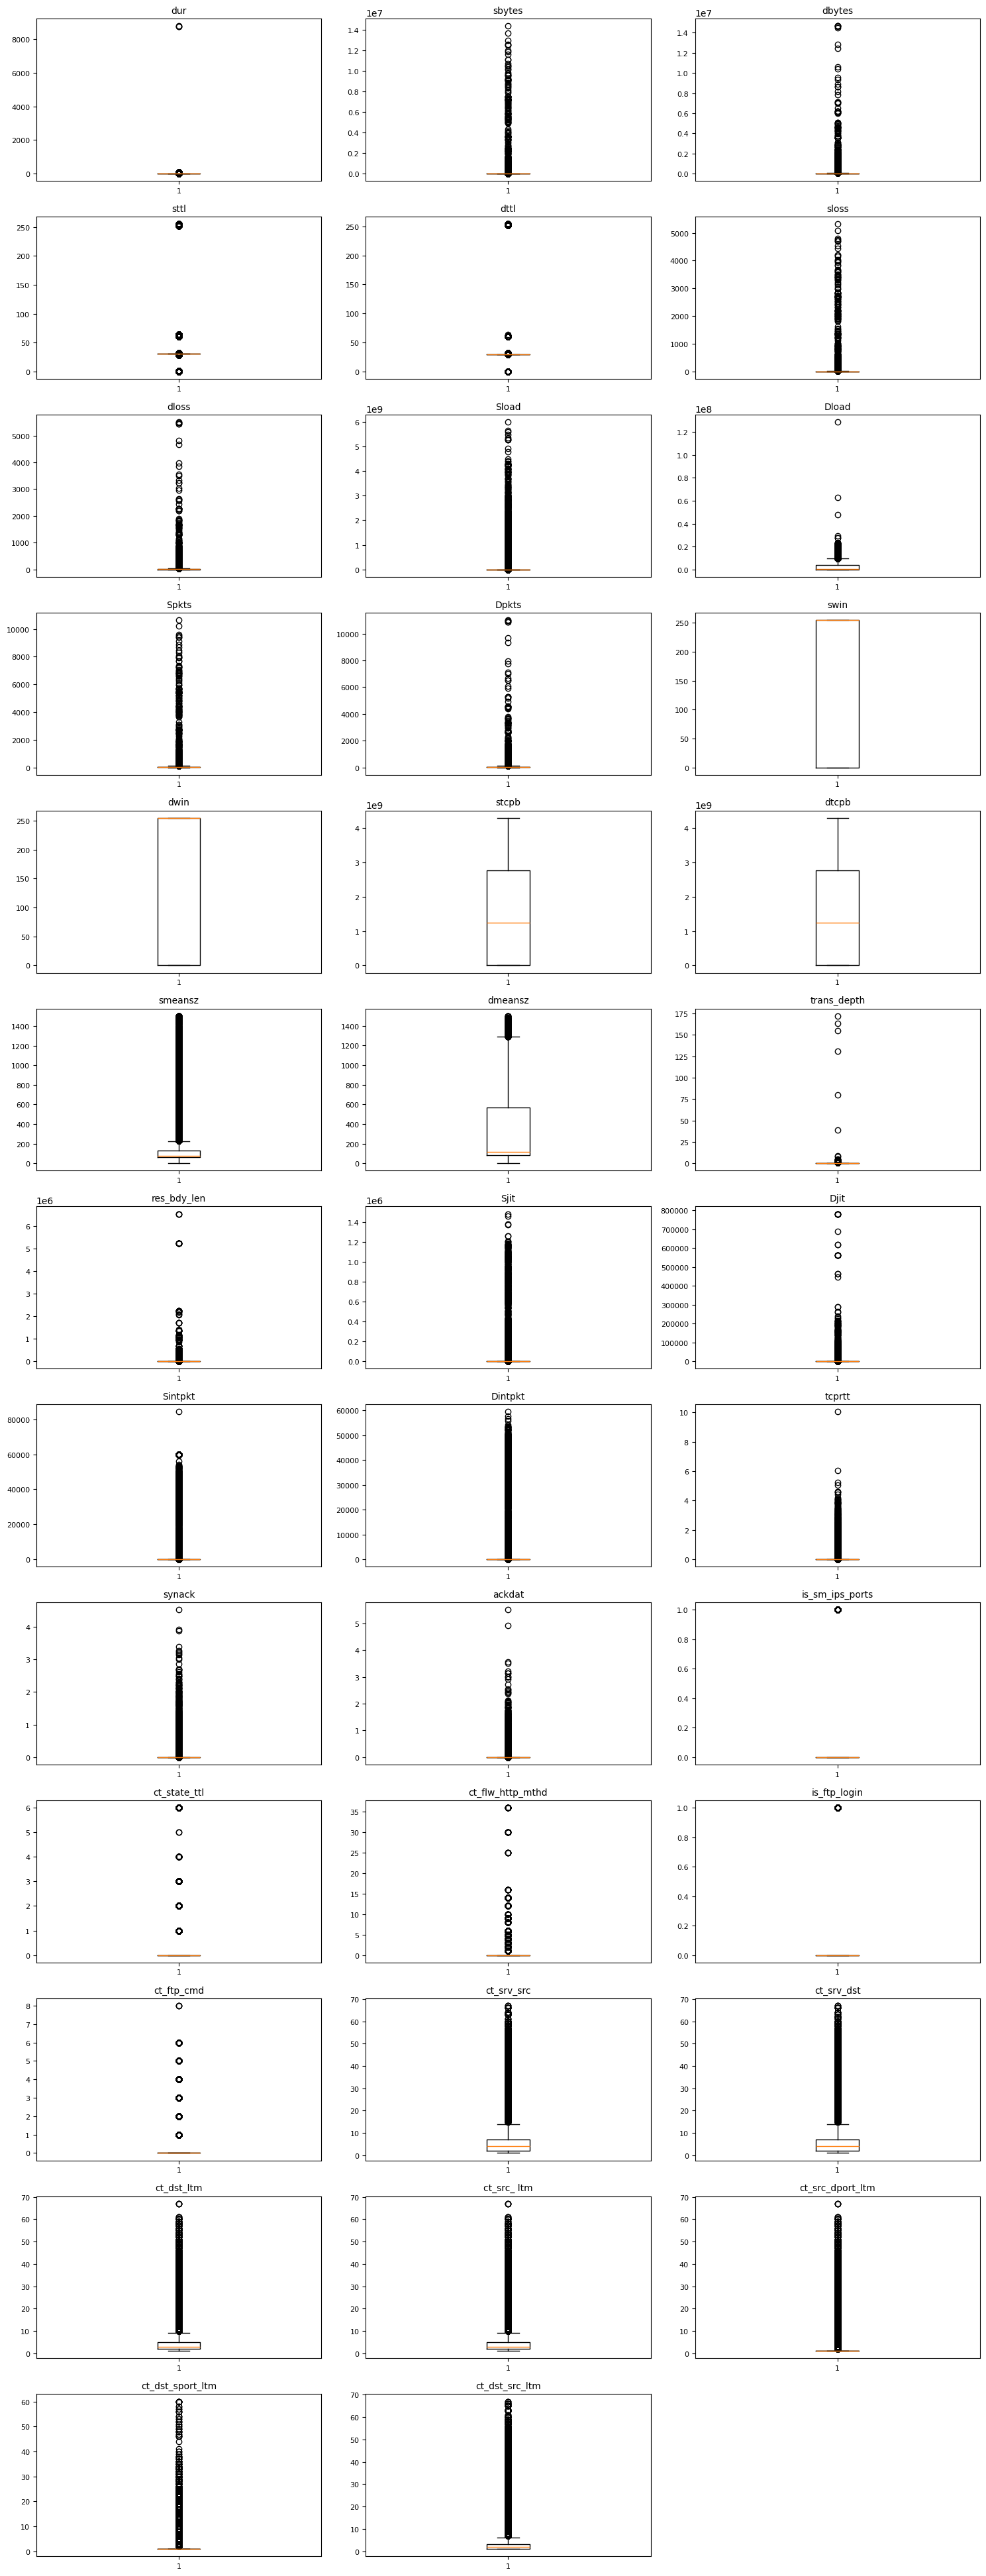

In [18]:
num_cols = X.columns.tolist()

n = len(num_cols)
n_cols = 3                     
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    ax.boxplot(X[col].dropna())
    ax.set_title(col, fontsize=10)
    ax.tick_params(labelsize=8)

for ax in axes[len(num_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Check target distribution

Class Distribution:
Label
0    1959771
1      99646
Name: count, dtype: int64

Percentage Distribution:
Label
0    95.161446
1     4.838554
Name: count, dtype: float64


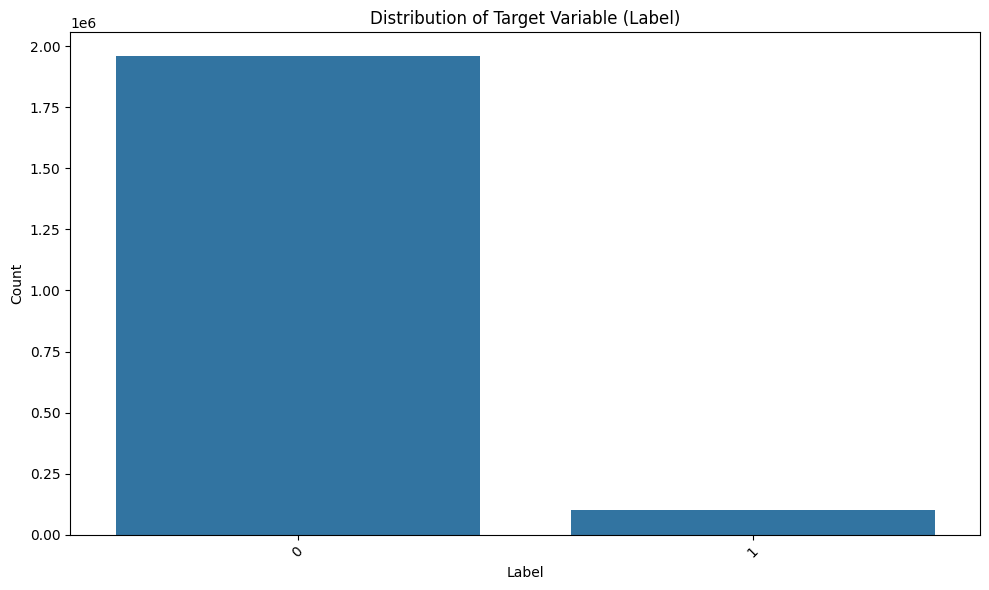

In [ ]:
# Count the distribution of the target variable 'Label'
label_counts = y.value_counts()

# Display the counts
print("Class Distribution:")
print(label_counts)
print("\nPercentage Distribution:")
print(label_counts / len(y) * 100)

# Create a bar plot to visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Target Variable (Label)')
plt.xlabel('Label')
plt.ylabel('Count')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Feature Correlation

<Axes: title={'center': 'FeatureCorrelation Plot'}, xlabel='Name', ylabel='Name'>

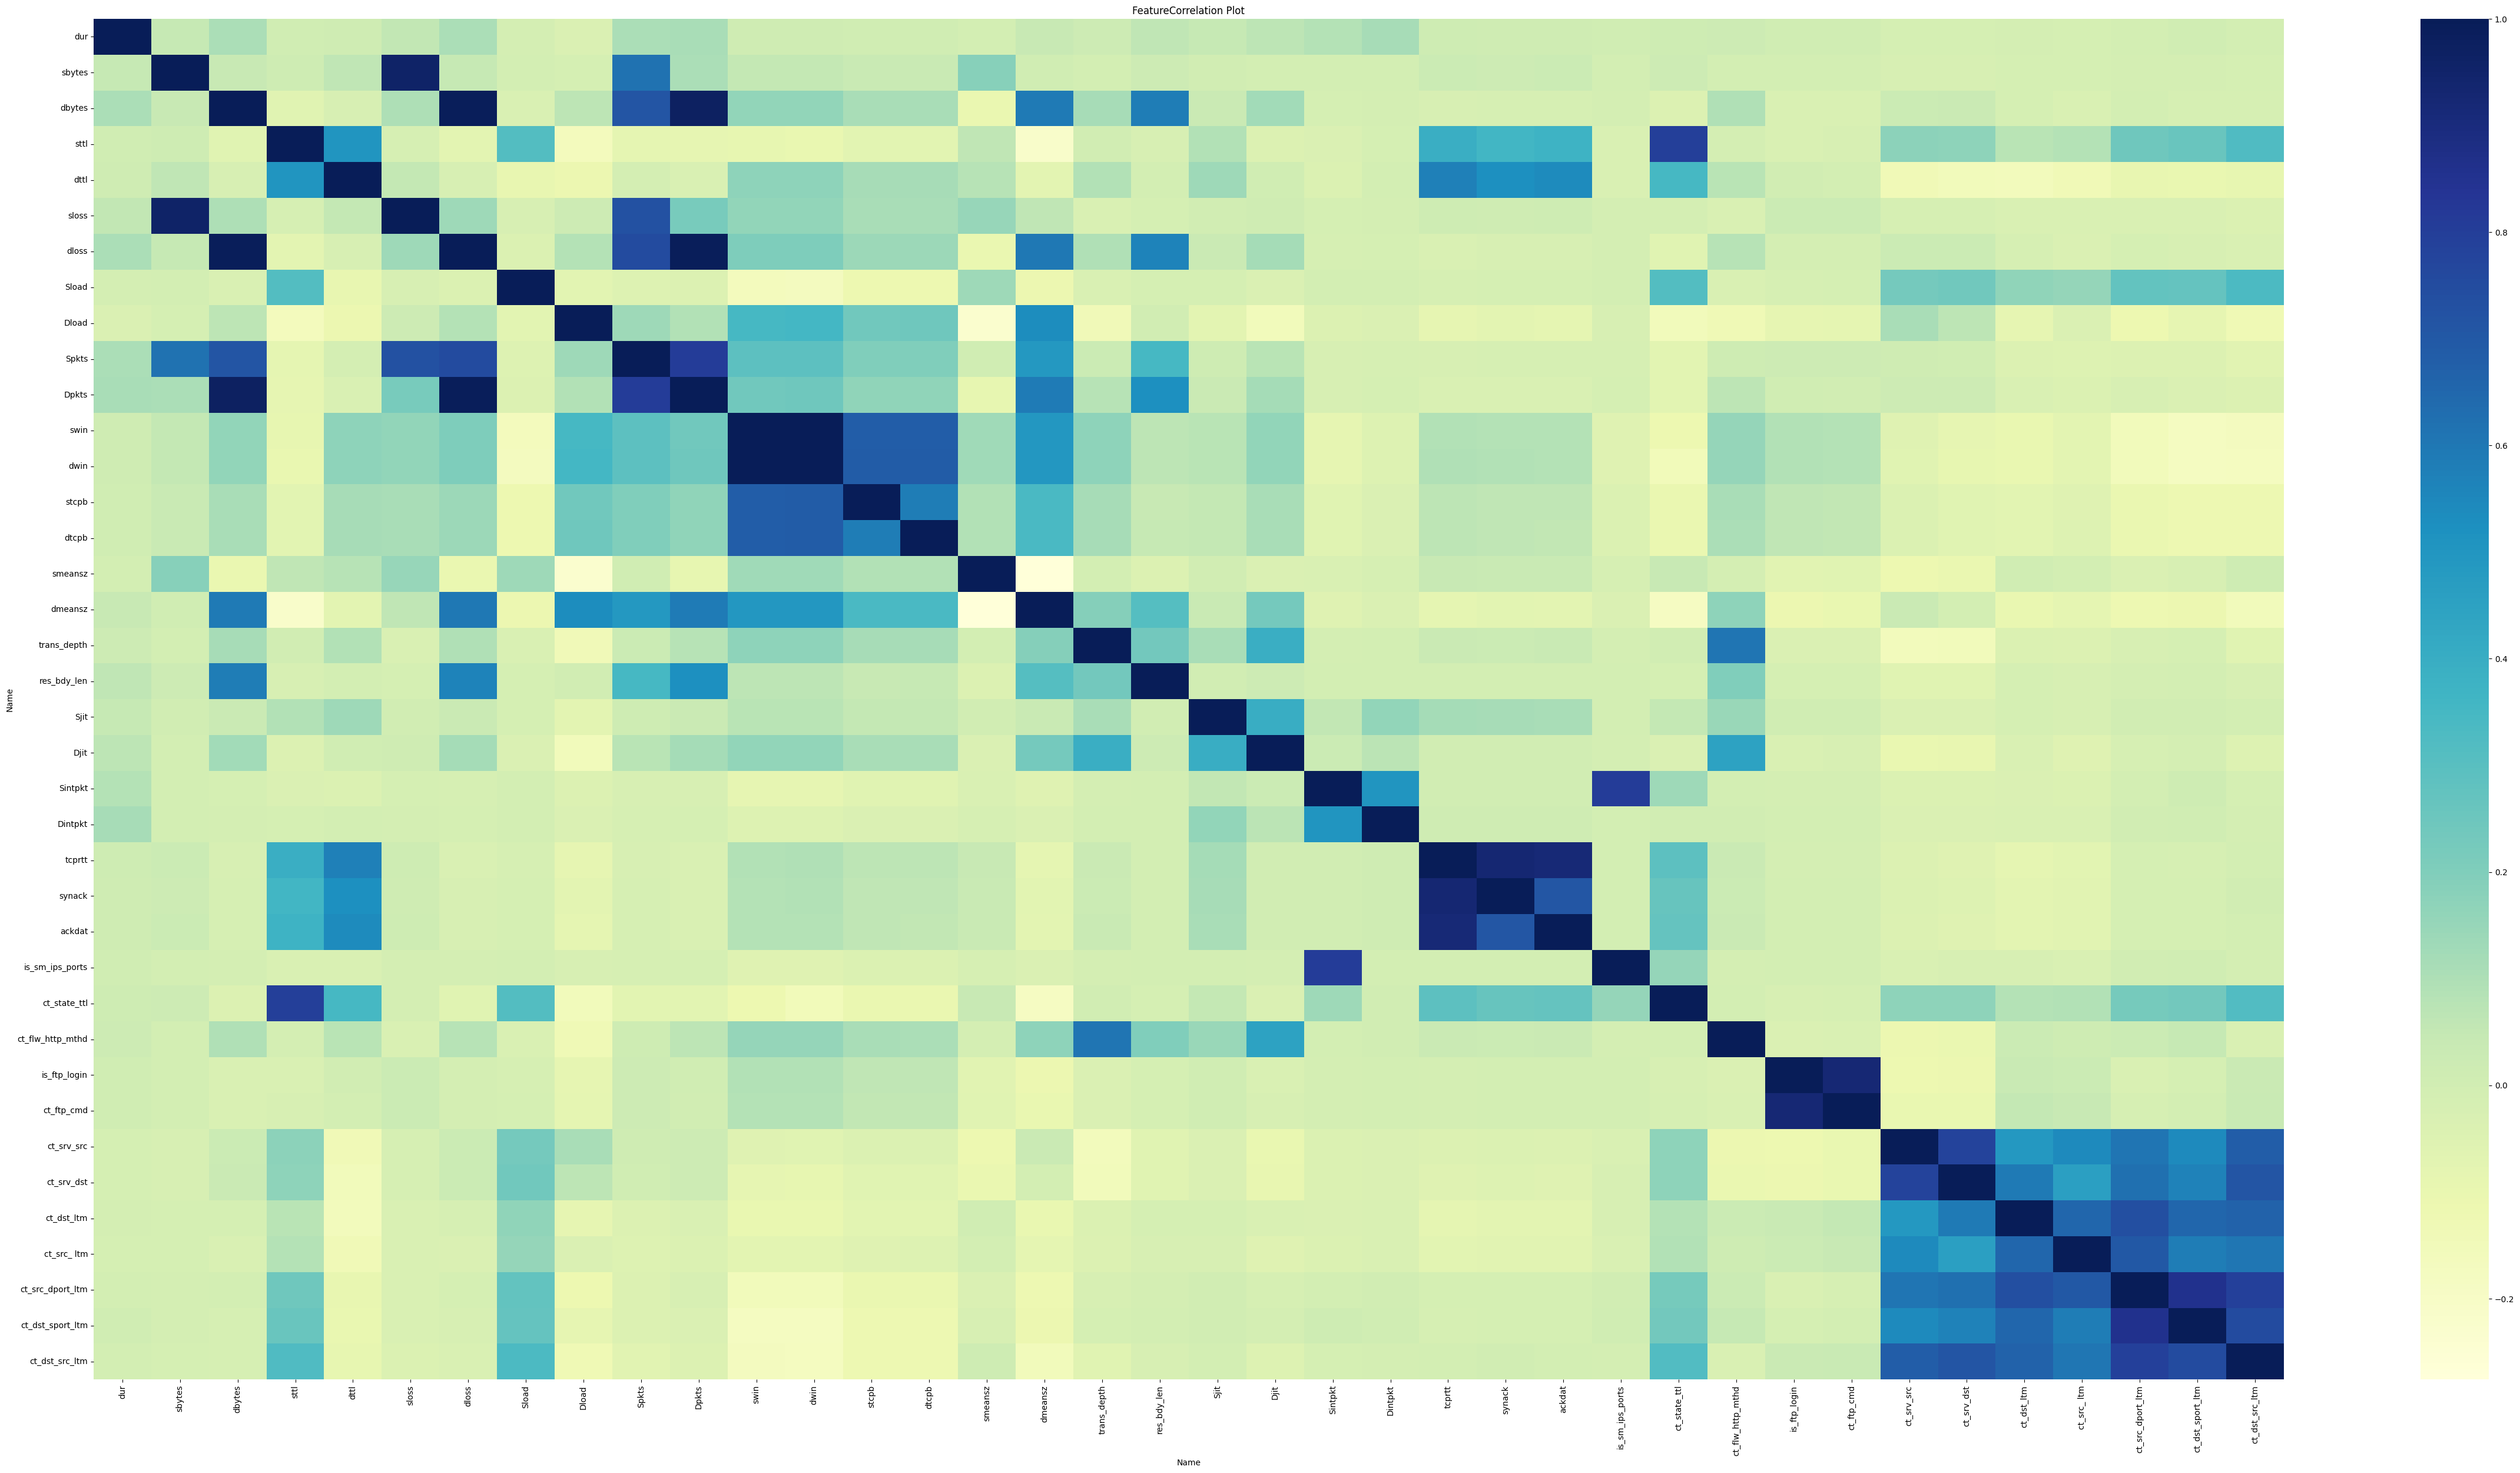

In [20]:
plt.figure(figsize=(60,30))
plt.title("FeatureCorrelation Plot")
sns.heatmap(X.corr(),cmap='YlGnBu')

#### Feature Distribution
# Create a figure with subplots for each numeric column



Highly correlated features (threshold = 0.7):
------------------------------------------------------------
Feature 1            Feature 2            Correlation
------------------------------------------------------------
swin                 dwin                 0.9965
dloss                Dpkts                0.9922
dbytes               dloss                0.9916
dbytes               Dpkts                0.9718
sbytes               sloss                0.9594
tcprtt               synack               0.9302
is_ftp_login         ct_ftp_cmd           0.9240
tcprtt               ackdat               0.9178
ct_src_dport_ltm     ct_dst_sport_ltm     0.8557
Spkts                Dpkts                0.8088
Sintpkt              is_sm_ips_ports      0.8071
sttl                 ct_state_ttl         0.7960
ct_src_dport_ltm     ct_dst_src_ltm       0.7928
ct_srv_src           ct_srv_dst           0.7851
dloss                Spkts                0.7513
ct_dst_sport_ltm     ct_dst_src_ltm       0

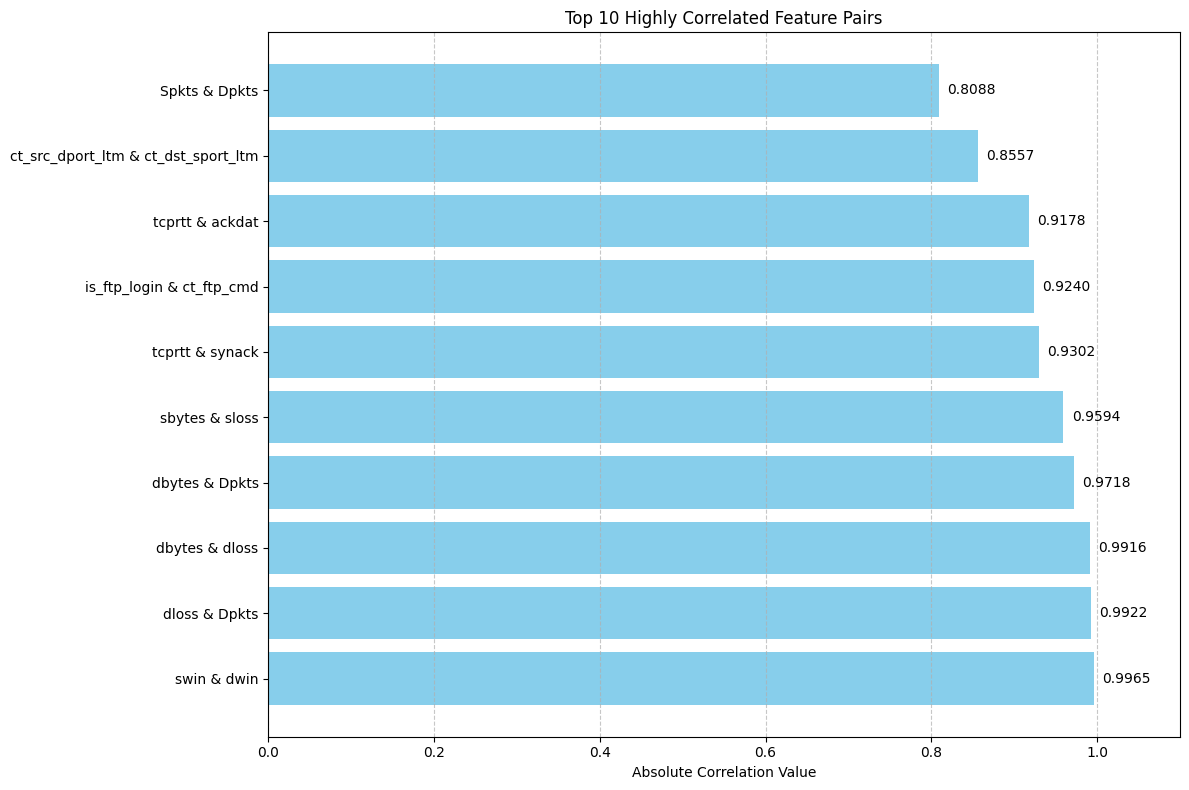

In [21]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Set a correlation threshold to identify highly correlated features
threshold = 0.7

# Find feature pairs with correlation above the threshold
high_corr_pairs = []

# Loop through the correlation matrix to find highly correlated pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Sort by correlation value (absolute) in descending order
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Print the highly correlated feature pairs
print(f"Highly correlated features (threshold = {threshold}):")
print("-" * 60)
print(f"{'Feature 1':<20} {'Feature 2':<20} {'Correlation':<10}")
print("-" * 60)

for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1:<20} {feat2:<20} {corr:.4f}")

# Create a visualization of the top N highly correlated pairs
if high_corr_pairs:
    top_n = min(10, len(high_corr_pairs))  # Show top 10 or all if less than 10
    
    plt.figure(figsize=(12, 8))
    
    # Extract data for plotting
    features1 = [pair[0] for pair in high_corr_pairs[:top_n]]
    features2 = [pair[1] for pair in high_corr_pairs[:top_n]]
    corr_values = [pair[2] for pair in high_corr_pairs[:top_n]]
    
    # Create bar chart
    bars = plt.barh(range(len(corr_values)), [abs(c) for c in corr_values], color='skyblue')
    
    # Add correlation values to the end of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{corr_values[i]:.4f}', va='center')
    
    # Set labels and title
    plt.yticks(range(len(corr_values)), [f"{f1} & {f2}" for f1, f2 in zip(features1, features2)])
    plt.xlabel('Absolute Correlation Value')
    plt.title(f'Top {top_n} Highly Correlated Feature Pairs')
    plt.xlim(0, 1.1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No feature pairs found with correlation above the threshold.")


In [22]:
# Create a set to keep track of features to drop
features_to_drop = set()

# Identify features to drop based on correlation
for feat1, feat2, corr in high_corr_pairs:
    if feat1 not in features_to_drop and feat2 not in features_to_drop:
        features_to_drop.add(feat2)

# Print features that will be dropped
print(f"Features to be dropped ({len(features_to_drop)}):")
for feature in features_to_drop:
    print(f"- {feature}")

# Create a new dataframe without the highly correlated features
if features_to_drop:
    X_reduced = X.drop(columns=list(features_to_drop))
    print(f"\nDataset shape before dropping features: {X.shape}")
    print(f"Dataset shape after dropping features: {X_reduced.shape}")
    
    # Update our working dataframe
    X = X_reduced
else:
    print("No features were dropped as none met the correlation threshold criteria.")


Features to be dropped (14):
- ct_state_ttl
- synack
- ct_src_dport_ltm
- ackdat
- Spkts
- ct_srv_dst
- Dpkts
- ct_dst_sport_ltm
- ct_ftp_cmd
- dloss
- is_sm_ips_ports
- sloss
- ct_dst_src_ltm
- dwin

Dataset shape before dropping features: (2059417, 38)
Dataset shape after dropping features: (2059417, 24)


In [23]:
print("Columns after dropping highly correlated features:")
print(X.columns)

Columns after dropping highly correlated features:
Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'Sload', 'Dload', 'swin',
       'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_ ltm'],
      dtype='object', name='Name')


#### Split data into training, validation and testing set

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1441591, 24)
Validation set shape: (308913, 24)
Testing set shape: (308913, 24)


#### Scale X

In [25]:
from sklearn.discriminant_analysis import StandardScaler

scaler    = StandardScaler()
X_train   = scaler.fit_transform(X_train)
X_val     = scaler.transform(X_val)
X_test    = scaler.transform(X_test)

#### PCA

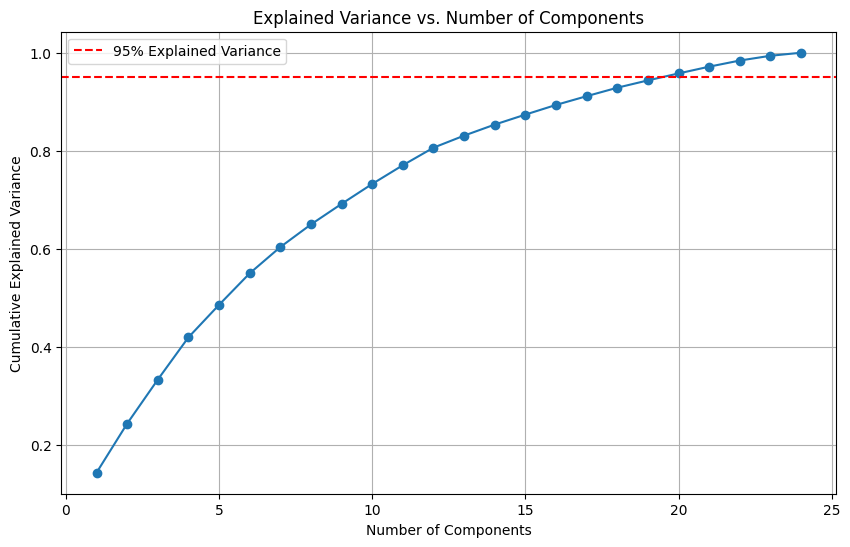

Number of components needed for 95% variance: 20
Original feature shape: (1441591, 24)
PCA reduced feature shape: (1441591, 20)


In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA
pca = PCA()

# Fit PCA on training data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Find number of components for 95% variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# Apply PCA with selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)
print(f"Original feature shape: {X_train.shape}")
print(f"PCA reduced feature shape: {X_train_pca.shape}")

# Update our working datasets
X_train = X_train_pca
X_test = X_test_pca
X_val = X_val_pca

### Training model

In [28]:
def make_loader(X_np, y_np, batch_size=256, shuffle=False):
    X_t = torch.from_numpy(X_np).float()
    y_t = torch.from_numpy(y_np).long()
    ds  = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train.values, shuffle=True)
val_loader   = make_loader(X_val,   y_val.values)
test_loader  = make_loader(X_test,  y_test.values)

In [29]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.3))
            prev = h
        layers.append(nn.Linear(prev, 2))       # 2 output classes
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = BaselineNN(input_dim=X_train.shape[1]).to(device)

In [32]:
from sklearn.metrics import f1_score


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs  = 15

for epoch in range(1, n_epochs+1):
    # — Train —
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss   = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # — Validate & compute F1 —
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds  = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    val_f1 = f1_score(y_true, y_pred, pos_label=1)

    print(f"Epoch {epoch:02d} — val F1: {val_f1:.4f}")

Epoch 01 — val F1: 0.8608
Epoch 02 — val F1: 0.8712
Epoch 03 — val F1: 0.8796
Epoch 04 — val F1: 0.8830
Epoch 05 — val F1: 0.8807
Epoch 06 — val F1: 0.8811
Epoch 07 — val F1: 0.8859
Epoch 08 — val F1: 0.8875
Epoch 09 — val F1: 0.8847
Epoch 10 — val F1: 0.8872
Epoch 11 — val F1: 0.8813
Epoch 12 — val F1: 0.8861
Epoch 13 — val F1: 0.8855
Epoch 14 — val F1: 0.8870
Epoch 15 — val F1: 0.8875


In [33]:
from sklearn.metrics import classification_report


model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)
test_f1 = f1_score(y_true, y_pred, pos_label=1)
print(f"\nTest F1: {test_f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=["benign","attack"]))


Test F1: 0.8901

              precision    recall  f1-score   support

      benign       1.00      0.99      0.99    293966
      attack       0.86      0.92      0.89     14947

    accuracy                           0.99    308913
   macro avg       0.93      0.96      0.94    308913
weighted avg       0.99      0.99      0.99    308913

